### OPL and ray tracing calculation for a system with tilted coverslip

1. Coordinate system: XY
  * X is the optical axis of objective, 
  * x=0 at the sample|coverslip boundary

2. units: mm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_sample = 1.37 #water: 1.33; life worm: 1.37; fixed and mounted in ProLong Gold: 1.47
# n= 1.37 @ 633 nm is C.elegans RI, ref: https://www.ncbi.nlm.nih.gov/pubmed/17694065/
n_glass = 1.5230 #@589 nm, D263M borosilicate glass for coverslips, from Fischer Scientific datasheet
n_media = 1.4722 #water (1.3325), glycerol(1.4722), immersion oil (1.515)
n_mediaArray = np.array([1.3325, 1.4722, 1.515]) #water, glycerol, immersion oil
mediaLabel = ['water','glycerol', 'oil']

tilt_angle = 45./180*np.pi #45-degree tilt of coverslip
thickness_glass = 0.170 #mm, No1.5 standard glass

thetaRadArray = np.linspace(-40,40,21)/180.0*np.pi ##ray angle from the point source

NA = np.sin(thetaRadArray[-1])*n_sample #max NA of the system, using sample refractive index
print 'max NA = ' + str(NA)

max NA = 0.880619025271


In [3]:
tilt_angle

0.7853981633974483

Two surfaces of the coverslip

In [4]:
def S1(x,tilt = 0.7853981633974483):
    """ first glass surface, closer to the sample. Default tilt 0.7853981633974483 rad is 45 deg. """
    return x*np.tan(tilt)

def S2(x,tilt = 0.7853981633974483,th_glass = 0.17):
    return x * np.tan(tilt) - th_glass/np.cos(tilt)

In [5]:
def ray_tracing(x0,y0,theta0, tilt, n_sample, n_glass, n_media, th_glass):
    """ Tracing of a ray emanating from point (x0,y0) at angle theta0 using Snell's law
    through tilted glass of thickness th_glass into immersion media, up to x3 axial position
    refr. indices: n_sample, n_glass, n_media,
    """
    # first refraction point
    x1 = x0 * np.tan(theta0)/(np.tan(theta0) - np.tan(tilt))
    y1 = S1(x1, tilt)
    theta1 = np.arcsin(n_sample/n_glass*np.sin(tilt + theta0)) - tilt
    # second refr. point
    x2 = x1 - th_glass/(np.cos(tilt)*(np.tan(theta1) - np.tan(tilt)))
    y2 = S2(x2,tilt,th_glass)
    theta2 = np.arcsin(n_glass/n_media * np.sin(tilt + theta1)) - tilt
    return (x1,y1,theta1, x2,y2,theta2)

Plot the ray fan.

Ignore invalid value warining in arcsin(), this is due to total internal reflection, these rays become 'nan' 

C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in arcsin


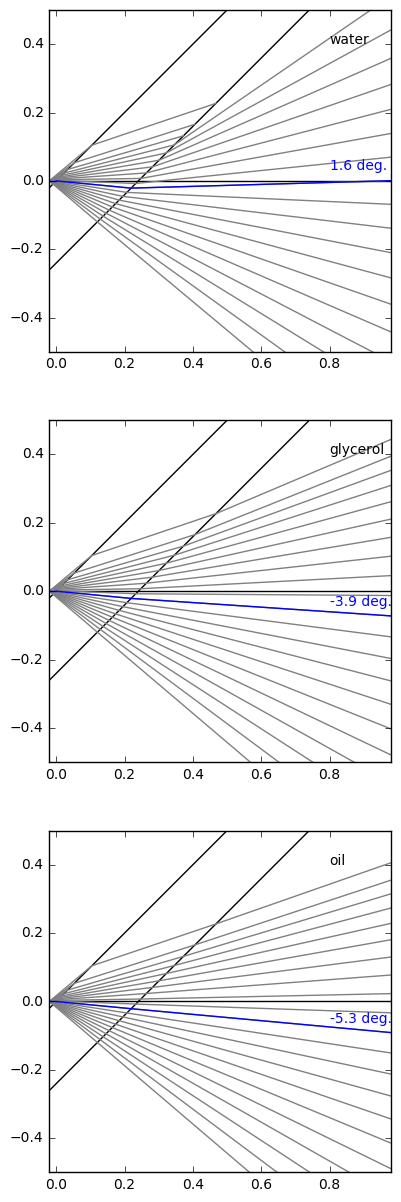

In [6]:
fig, ax = plt.subplots(3,1,figsize = (5,15))
x_min = -0.1
x_max = 1.
axialRayInd = np.where(thetaRadArray == 0)[0]
for i in range(3):
    ax[i].plot([x_min, x_max],[S1(x_min), S1(x_max)],'-k')
    ax[i].plot([x_min, x_max],[S2(x_min), S2(x_max)],'-k')
    ax[i].axhline(y=0, color='k')
    ax[i].set_aspect('equal', 'box')
    x0, y0 = -0.02, 0
    (x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                      n_sample, n_glass, n_mediaArray[i], thickness_glass)
    x3 = x_max*np.ones(len(thetaRadArray))
    y3 = y3 = y2 + (x3-x2)*np.tan(theta2)
    #plot all rays
    ax[i].plot([x0*np.ones(len(thetaRadArray)), x1], [y0*np.ones(len(thetaRadArray)), y1],color = 'gray')
    ax[i].plot([x1, x2], [y1, y2],color = 'gray')
    ax[i].plot([x2, x3], [y2, y3],color = 'gray')
    #plot axial ray
    ax[i].plot([x0, x1[axialRayInd]], [y0, y1[axialRayInd]],color = 'blue')
    ax[i].plot([x1[axialRayInd], x2[axialRayInd]], [y1[axialRayInd], y2[axialRayInd]],color = 'blue')
    ax[i].plot([x2[axialRayInd], x3[axialRayInd]], [y2[axialRayInd], y3[axialRayInd]],color = 'blue')
    # print axis ray angle, deg.
    ax[i].text(0.8, y3[axialRayInd]+0.03, '{:2.1f}'.format(theta2[axialRayInd][0]/np.pi*180) + ' deg.',color='blue')
    ax[i].set_xlim([-0.02, 0.98])
    ax[i].set_ylim([-0.5, 0.5])
    ax[i].text(0.8,0.4,mediaLabel[i])

Find where rays reach the reference sphere (R_refSphere)

In [7]:
n_media = 1.4722
x0, y0 = -0.02, 0
R_refSphere = 1.0
x3_refSphere = np.zeros(thetaRadArray.shape)
y3_refSphere = np.zeros(thetaRadArray.shape)
i = 0
for theta0 in thetaRadArray:
    (x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, theta0, tilt_angle, \
                                                n_sample, n_glass, n_media, thickness_glass)
    # solve quadratic equation to find where ray3 intersects ref. sphere
    a = 1 + np.tan(theta2)**2
    b = 2*y2*np.tan(theta2) - 2*x2*np.tan(theta2)**2 - 2*x0
    c = (y2 - x2*np.tan(theta2))**2 - R_refSphere**2 + x0**2
    x3_refSphere[i] = (-b + np.sqrt(b**2-4*a*c))/(2*a)
    y3_refSphere[i] = y2 + (x3_refSphere[i]-x2)*np.tan(theta2)
    i+=1

In [8]:
def intersectRefSphere(x0,y0,x2,y2,theta2,r):
    """Solve quadratic equation to find where ray3 intersects ref. sphere"""
    a = 1.0 + np.tan(theta2)**2
    b = 2.0*y2*np.tan(theta2) - 2.0*x2*np.tan(theta2)**2 - 2.0*x0
    c = (y2 - y0 - x2*np.tan(theta2))**2 - r**2 + x0**2
    x3_refSphere = (-b + np.sqrt(b**2 - 4.0*a*c))/(2*a)
    y3_refSphere = y2 + (x3_refSphere - x2)*np.tan(theta2)
    return (x3_refSphere, y3_refSphere)

In [9]:
def ref_sphere(x0, y0, r):
    """Generates x,y pairs for drawing a sphere"""
    theta = np.linspace(0,2*np.pi,100)
    return (x0 + r*np.cos(theta), y0 + r*np.sin(theta))

C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in arcsin


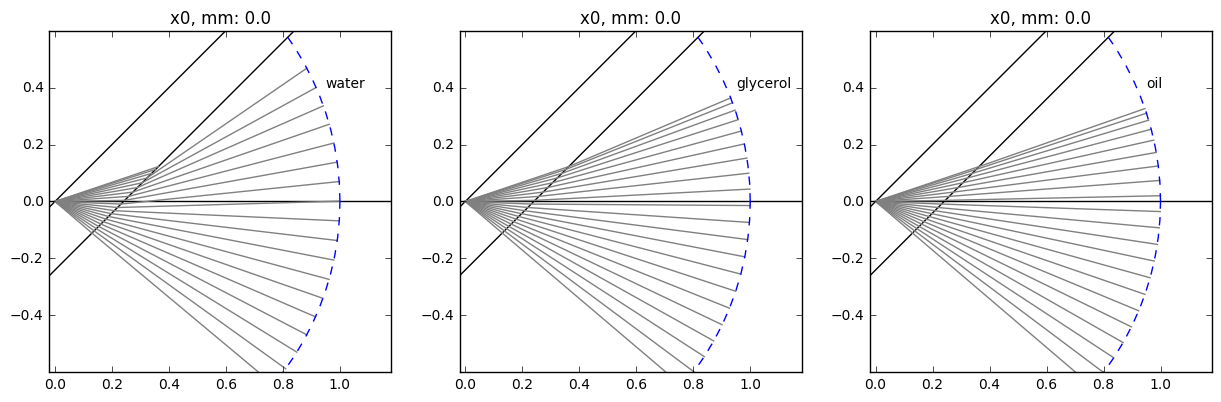

In [14]:
R_refSphere = 1.0 #mm
fig, ax = plt.subplots(1,3,figsize = (15,5))
x_min = -0.1
x_max = 2.
for i in range(3):
    ax[i].plot([x_min, x_max],[S1(x_min), S1(x_max)],'-k')
    ax[i].plot([x_min, x_max],[S2(x_min), S2(x_max)],'-k')
    ax[i].axhline(y=0, color='k')
    ax[i].set_aspect('equal', 'box')
    x0, y0 = 0.0, 0
    (x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                      n_sample, n_glass, n_mediaArray[i], thickness_glass)
    (x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2,theta2,R_refSphere)
    ax[i].plot([x0*np.ones(len(thetaRadArray)), x1], [y0*np.ones(len(thetaRadArray)), y1],color = 'gray')
    ax[i].plot([x1, x2], [y1, y2],color = 'gray')
    ax[i].plot([x2, x3_refSphere], [y2, y3_refSphere],color = 'gray')
    
    (x_sphere,y_sphere) = ref_sphere(x0, y0, R_refSphere)
    ax[i].plot(x_sphere,y_sphere, '--b')
    ax[i].set_xlim([-0.02, 1.18])
    ax[i].set_ylim([-0.6, 0.6])
    ax[i].text(0.95,0.4,mediaLabel[i])
    ax[i].set_title('x0, mm: ' + str(x0))

C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in arcsin


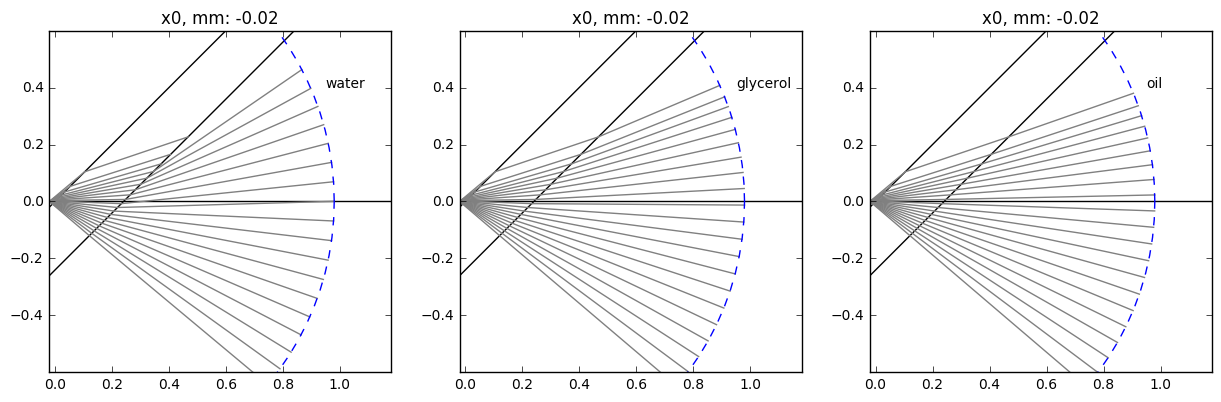

In [13]:
R_refSphere = 1.0 #mm
fig, ax = plt.subplots(1,3,figsize = (15,5))
x_min = -0.1
x_max = 2.
for i in range(3):
    ax[i].plot([x_min, x_max],[S1(x_min), S1(x_max)],'-k')
    ax[i].plot([x_min, x_max],[S2(x_min), S2(x_max)],'-k')
    ax[i].axhline(y=0, color='k')
    ax[i].set_aspect('equal', 'box')
    x0, y0 = -0.02, 0
    (x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                      n_sample, n_glass, n_mediaArray[i], thickness_glass)
    (x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2,theta2,R_refSphere)
    ax[i].plot([x0*np.ones(len(thetaRadArray)), x1], [y0*np.ones(len(thetaRadArray)), y1],color = 'gray')
    ax[i].plot([x1, x2], [y1, y2],color = 'gray')
    ax[i].plot([x2, x3_refSphere], [y2, y3_refSphere],color = 'gray')
    
    (x_sphere,y_sphere) = ref_sphere(x0, y0, R_refSphere)
    ax[i].plot(x_sphere,y_sphere, '--b')
    ax[i].set_xlim([-0.02, 1.18])
    ax[i].set_ylim([-0.6, 0.6])
    ax[i].text(0.95,0.4,mediaLabel[i])
    ax[i].set_title('x0, mm: ' + str(x0))

## Plot optical path length (OPL) of the rays

C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in arcsin


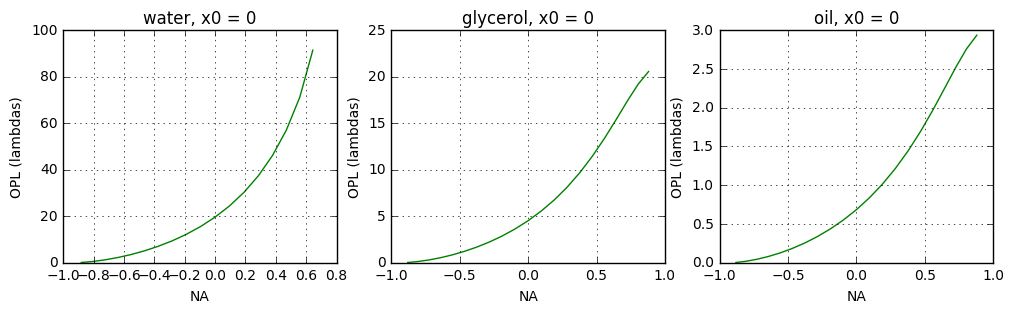

In [17]:
source_x_position = 0
wl = 0.589e-3 # green wl in vacuum, mm
R_refSphere = 2.0
thetaRadArray = np.linspace(-40,40,21)/180.0*np.pi #ray angle from the point source

fig, ax = plt.subplots(1,3,figsize = (12,3))
for i in range(3):
    n_media = n_mediaArray[i]
    x0, y0 = source_x_position, 0
    (x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                                n_sample, n_glass, n_media, thickness_glass)
    
    (x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2,theta2,R_refSphere)
    
    OPL = n_sample * np.sqrt((x1-x0)**2 + (y1-y0)**2) + \
           n_glass * np.sqrt((x2-x1)**2 + (y2-y1)**2) + \
           n_media * np.sqrt((x3_refSphere-x2)**2 + (y3_refSphere-y2)**2)
        
    OPL = OPL/wl
    ax[i].grid()
    ax[i].plot(np.sin(thetaRadArray)*n_sample,OPL - np.nanmin(OPL), '-g')
    ax[i].set_xlabel('NA')
    ax[i].set_ylabel('OPL (lambdas)')
    ax[i].set_title(mediaLabel[i] + ', x0 = ' + str(source_x_position))

C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in arcsin


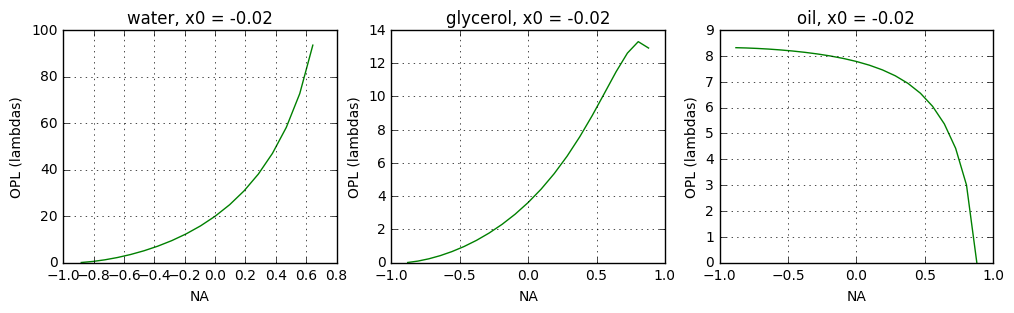

In [16]:
source_x_position = -0.02
wl = 0.589e-3 # green wl in vacuum, mm
R_refSphere = 2.0
thetaRadArray = np.linspace(-40,40,21)/180.0*np.pi #ray angle from the point source

fig, ax = plt.subplots(1,3,figsize = (12,3))
for i in range(3):
    n_media = n_mediaArray[i]
    x0, y0 = source_x_position, 0
    (x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                                n_sample, n_glass, n_media, thickness_glass)
    
    (x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2,theta2,R_refSphere)
    
    OPL = n_sample * np.sqrt((x1-x0)**2 + (y1-y0)**2) + \
           n_glass * np.sqrt((x2-x1)**2 + (y2-y1)**2) + \
           n_media * np.sqrt((x3_refSphere-x2)**2 + (y3_refSphere-y2)**2)
        
    OPL = OPL/wl
    ax[i].grid()
    ax[i].plot(np.sin(thetaRadArray)*n_sample,OPL - np.nanmin(OPL), '-g')
    ax[i].set_xlabel('NA')
    ax[i].set_ylabel('OPL (lambdas)')
    ax[i].set_title(mediaLabel[i] + ', x0 = ' + str(source_x_position))

## Simulate for a range of immersion media RI

C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in arcsin


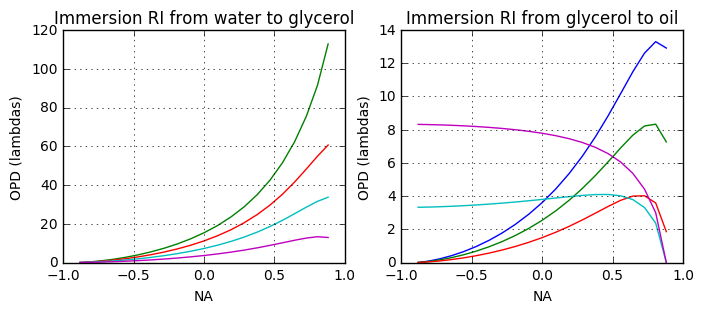

In [90]:
R_refSphere = 2.0
thetaRadArray = np.linspace(-40,40,21)/180.0*np.pi #ray angle from the point source
x0, y0 = -0.02, 0

fig, ax = plt.subplots(1,2,figsize = (8,3))
for i in range(2):
    for n_media in np.linspace(n_mediaArray[i], n_mediaArray[i+1], 5):
        (x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                                    n_sample, n_glass, n_media, thickness_glass)

        (x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2,theta2,R_refSphere)

        opl = n_sample * np.sqrt((x1-x0)**2 + (y1-y0)**2) + \
               n_glass * np.sqrt((x2-x1)**2 + (y2-y1)**2) + \
               n_media * np.sqrt((x3_refSphere-x2)**2 + (y3_refSphere-y2)**2)

        opl = opl/wl
        ax[i].grid()
        ax[i].plot(np.sin(thetaRadArray)*n_sample,opl - opl.min())
        ax[i].set_xlabel('NA')
        ax[i].set_ylabel('OPD (lambdas)')

ax[0].set_title('Immersion RI from water to glycerol')
ax[1].set_title('Immersion RI from glycerol to oil')

Find immersion media RI which gives minimum OPD,

for a source **20 um** away from coverslip

In [92]:
R_refSphere = 2.0
thetaRadArray = np.linspace(-40,40,101)/180.0*np.pi #ray angle from the point source
x0, y0 = -0.020, 0
OPD = []
RI = []

for n_media in np.linspace(n_mediaArray[0], n_mediaArray[2], 100):
        (x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                                    n_sample, n_glass, n_media, thickness_glass)

        (x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2,theta2,R_refSphere)

        opl = n_sample * np.sqrt((x1-x0)**2 + (y1-y0)**2) + \
               n_glass * np.sqrt((x2-x1)**2 + (y2-y1)**2) + \
               n_media * np.sqrt((x3_refSphere-x2)**2 + (y3_refSphere-y2)**2)

        opl = opl/wl
        OPD.append(np.nanmax(opl) - np.nanmin(opl))
        RI.append(n_media)

OPD = np.asarray(OPD)
RI = np.asarray(RI)
min_index = np.where(OPD == OPD.min())
print 'source 20 um away from coveslip'
print 'min OPD = ' + str(OPD.min()) + ' wl'
print 'optimal RI of immersion media = ' + str(RI[min_index])
print 'RI of glycerol = ' + str(n_mediaArray[1])
print 'RI of oil = ' + str(n_mediaArray[2])

source 20 um away from coveslip
min OPD = 2.89807935433 wl
optimal RI of immersion media = [ 1.49840909]
RI of glycerol = 1.4722
RI of oil = 1.515


C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in arcsin


.. for a source next to coverslip

In [93]:
x0, y0 = -0.001, 0
OPD = []
RI = []

for n_media in np.linspace(n_mediaArray[0], n_mediaArray[2], 100):
        (x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                                    n_sample, n_glass, n_media, thickness_glass)

        (x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2,theta2,R_refSphere)

        opl = n_sample * np.sqrt((x1-x0)**2 + (y1-y0)**2) + \
               n_glass * np.sqrt((x2-x1)**2 + (y2-y1)**2) + \
               n_media * np.sqrt((x3_refSphere-x2)**2 + (y3_refSphere-y2)**2)

        opl = opl/wl
        OPD.append(np.nanmax(opl) - np.nanmin(opl))
        RI.append(n_media)
        
OPD = np.asarray(OPD)
RI = np.asarray(RI)
min_index = np.where(OPD == OPD.min())
print '0 um away from coveslip'
print 'min OPD = ' + str(OPD.min()) + ' wl'
print 'optimal RI of immersion media = ' + str(RI[min_index])
print 'RI of glycerol = ' + str(n_mediaArray[1])
print 'RI of oil = ' + str(n_mediaArray[2])

0 um away from coveslip
min OPD = 2.47107936061 wl
optimal RI of immersion media = [ 1.515]
RI of glycerol = 1.4722
RI of oil = 1.515


C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in arcsin


.. for a source 40 um away from coverslip

In [94]:
x0, y0 = -0.040, 0
OPD = []
RI = []

for n_media in np.linspace(n_mediaArray[0], n_mediaArray[2], 100):
        (x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                                    n_sample, n_glass, n_media, thickness_glass)

        (x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2,theta2,R_refSphere)

        opl = n_sample * np.sqrt((x1-x0)**2 + (y1-y0)**2) + \
               n_glass * np.sqrt((x2-x1)**2 + (y2-y1)**2) + \
               n_media * np.sqrt((x3_refSphere-x2)**2 + (y3_refSphere-y2)**2)

        opl = opl/wl
        OPD.append(np.nanmax(opl) - np.nanmin(opl))
        RI.append(n_media)
        
OPD = np.asarray(OPD)
RI = np.asarray(RI)
min_index = np.where(OPD == OPD.min())
print '40 um away from coveslip'
print 'min OPD = ' + str(OPD.min()) + ' wl'
print 'optimal RI of immersion media = ' + str(RI[min_index])
print 'RI of glycerol = ' + str(n_mediaArray[1])
print 'RI of oil = ' + str(n_mediaArray[2])

40 um away from coveslip
min OPD = 6.12296775285 wl
optimal RI of immersion media = [ 1.47628788]
RI of glycerol = 1.4722
RI of oil = 1.515


C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in arcsin
